# k means ||

In [1]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("prova iniziale")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/09/05 10:52:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark

In [3]:
# create a spark context
sc = spark.sparkContext

# print its status
sc

<SparkContext master=spark://spark-master:7077 appName=prova iniziale>

# Import data from sklearn (load in the disk)

This is going to be removed in the Cloud Veneto version


In [4]:
sc.setLogLevel("ERROR") # To hide warnings

In [5]:
!pip install scikit-learn # to be run at the launch of "docker compose up" 

In [6]:
import numpy as np
import pandas as pd
import random
import sklearn.datasets #va installato
import time

# from pyspark.sql.functions import sum
from pyspark.sql.functions import col
from pyspark.sql.functions import mean
from pyspark.sql.functions import stddev
from pyspark.sql.functions import rand
from pyspark.sql.functions import least
from pyspark.sql import Row
from pyspark.ml.feature import StandardScaler

from IPython.display import Image
import matplotlib.pyplot as plt

In [7]:
# Hyperparameters
k = 6
G = 3 # Giosu factor
len_df = 300 #494_021

In [8]:
all_points = pd.DataFrame(columns = ['x','y'])
color_points = pd.DataFrame(columns = ['x','y','color'])

In [9]:
Image('two_categories_scatter_plot.png')

category = k # Number of cathegories shown in the plot
points = len_df #300 # Resolution of the plotted graphics

fig = plt.figure(figsize=(5, 5))
n=0

mycols = ['blue','red','green','orange','pink','purple']
while n < category:
    std_x, mean_x = np.random.random(), np.random.randint(-10, 10)
    std_y, mean_y = np.random.random(), np.random.randint(-10, 10)

    gaussian_x = np.random.normal(mean_x, std_x, points)
    gaussian_y = np.random.normal(mean_y, std_y, points)
    
    data_xy = pd.DataFrame({'x':gaussian_x,'y':gaussian_y})
    data_rgb = pd.DataFrame({'x':gaussian_x,'y':gaussian_y,'color':mycols[n]})
    all_points = pd.concat([all_points,data_xy])
    color_points = pd.concat([color_points,data_rgb])
    
    plt.scatter(gaussian_x, gaussian_y,alpha=0.35)
    print('The category', n+1, 'has the two gaussians:', mean_x, '+-', std_x, 'and', mean_y, '+-', std_y)
    n += 1

    
    
plt.show()

The category 1 has the two gaussians: -9 +- 0.9816805766309092 and -3 +- 0.26904296414087625
The category 2 has the two gaussians: -10 +- 0.4203557325322451 and 9 +- 0.9113598132047472
The category 3 has the two gaussians: -7 +- 0.9439844204821437 and -5 +- 0.1696925498234665
The category 4 has the two gaussians: 3 +- 0.029116605679769925 and -9 +- 0.044806352629521706
The category 5 has the two gaussians: -9 +- 0.37791963234359294 and 0 +- 0.22279702389887468
The category 6 has the two gaussians: -6 +- 0.6597220708703843 and 9 +- 0.46410826599515853


<Figure size 500x500 with 0 Axes>

In [10]:
color_points.count()

x        1800
y        1800
color    1800
dtype: int64

In [11]:
X = all_points
X.count()

x    1800
y    1800
dtype: int64

In [12]:
n_cols = len(X.iloc[0])

In [13]:
# Show the dataframe (to be deleted for a bigger dataframe) (TO BE DELETED)
n_cols

2

# Create a Spark dataframe
And then acquire important informations about the dataframe: # columns, # rows, # partitions, the schema, ...

In [14]:
# Create the spark dataframe with a smaller chunk of data (just to work easily)
spark_X = spark.createDataFrame(X)
spark_X.persist()

/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/bin/spark-3.3.2-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


DataFrame[x: double, y: double]

In [15]:
# Check the number of partitions the DataFrame is divided into the three workers yet
spark_X.rdd.getNumPartitions()

3

In [16]:
# Define a function that is able to select the single row in the dataframe
def getrows(df, rownums=None): # copied from the internet
    return df.rdd.zipWithIndex().filter(lambda x: x[1] in rownums).map(lambda x: x[0])

In [17]:
# Define the number of rows and columns in the dataframe
n_rows = spark_X.count()

In [18]:
# Delete the non-numerical values in an easy way
# clean_X = spark_X.select('*').drop('protocol_type', 'service', 'flag')
# clean_X.printSchema()

# Delete the non-numerical values in a reusable way
col_type = np.array(spark_X.dtypes)
types = col_type[:,1] 
colnames = col_type[:,0]
clean_X = spark_X.select([col(colnames[i]) for i in range(len(colnames)) if not types[i] == 'binary'])

# Step 0: Useful functions for the initialization

In [19]:
# Define the function for the distance between the cluster centers and the pandas dataframe
def distance(xrow, centers, num_cols=n_cols):
    '''Distance between a dataframe.row
    and the broadcasted value list of centers
    in the form of dataframe.row.value:
    
    broadC = sc.broadcast(center_rows).value
    xrow = clean_X.collect()[1]
    '''
    x = np.array(xrow)[:num_cols]
    the_ds = np.zeros(len(centers))
    
    for c in range(len(centers)):
        c_array = np.array(centers[c])[:num_cols]
        dist2 = np.linalg.norm(x - c_array)**2
        the_ds[c] = dist2
        
    return np.min(the_ds)

# Formula to evaluate the oversamping factor with the pre-factor G
def evaluate_l(log_phi, k, G):
    return G * k/log_phi # G = over-oversampling factor

# Function to select a row based on its probability
def select_row(x):
    if x > np.random.uniform(low = 0, high = 1):
        return True
    else:
        return False


### This is NOT $\Phi$. This is $log(\Phi)$. Pay attention budeo.

# Step 1: Choose a random sample from the dataset
This is the required step to begin the algorithm (doesn't need to be parallelized, since it is a select task)

In [20]:
# Choose the first sample randomly: select the random row
random_n = [np.random.randint(0, n_rows)]
random_sample = getrows(clean_X, random_n).collect()

# Step 2: Initial cost
Then we evaluate the cost function (sum of the squares after the first selection)

In [21]:
colnames = list(clean_X.dtypes[i][0] for i in range(len(clean_X.dtypes)))

In [22]:
# Add the colunm to keep the minimum distance between each point and the closest center
clean_X = (clean_X.select('*')
           .withColumn('minimum_cost', sum((col(colname)-random_sample[0][colname])**2 for colname in colnames)))

In [23]:
# Initial cost
initial_cost = np.log(clean_X.agg({"minimum_cost": "sum"}).collect()[0][0])
initial_cost

12.516292652525557

In [24]:
# Add the newly introduced value to the row that I selected in the first place
temp = random_sample[0].asDict()
temp["minimum_cost"] = 0.
random_sample[0] = Row(**temp)

In [25]:
# Broadcasting the row over the workers
bCent = sc.broadcast(random_sample)

# To show the content of the broadcast: b.value

## Step 2.5: evaluate number of iterations

After having evaluated $\log \phi$, we find a number of iterations which is of the same order of magnitude.

In [26]:
n_iter = int(initial_cost)
n_iter

12

# Step 3: For loop
Implement the for loop in order to evaluate probabilities and choose new centers



In [27]:
phi_iter = initial_cost
l = evaluate_l(phi_iter, k, G)
l

1.4381255296365998

In [28]:
%%time

i = 0
last_centers = 1
start_time = time.time()

while i < n_iter:   # or len(bCent.value) < k: # added as a safety condition (useless for very long datasets)

        '''
        Nel ciclo for:
            - Evaluate for each row l * d()^2 / phi
            - Sample with that probability
            - Broadcast centers to nodes
            - Evaluate new cost

        Ricordiamoci che distance è già al quadrato e che phi è il logaritmo
        '''

        # Evaluate the probability and select the new rows
        mod_phi = l/np.exp(phi_iter)
        new_rows = clean_X.select('*').withColumn('random_number', rand(seed=int(time.time())))\
                          .filter(col('random_number') < col('minimum_cost')*mod_phi).drop('random_number').collect()

        print("--- %s seconds ---" % (time.time() - start_time))
        start_time = time.time()
        
        # Update the broadcast in a non-usual way (newest at the beginning)
        bCent = sc.broadcast(new_rows + bCent.value)
        
        print("--- %s seconds ---" % (time.time() - start_time))
        start_time = time.time()

        # Update the minimum distance
        if len(new_rows) == 1:
            clean_X = clean_X.select('*').\
                      withColumn('minimum_cost', least('minimum_cost', sum((col(colname)-bCent.value[0][colname])**2 for colname in colnames) )).cache()

        elif len(new_rows) > 1:
            clean_X = clean_X.select('*').withColumn('dummy', least(*[sum((col(colname)-bCent.value[center][colname])**2 for colname in colnames) for center in range(len(new_rows))] )).\
                      withColumn('minimum_cost', least('minimum_cost', 'dummy')).\
                      drop('dummy').cache()

        last_centers = len(bCent.value)

        # Evaluate new cost
        phi_iter = np.log(clean_X.agg({"minimum_cost": "sum"}).collect()[0][0])

        print("--- %s seconds ---" % (time.time() - start_time))
        start_time = time.time()

        i += 1

        print("\n at iteration", i ,", #values: ",len(bCent.value), " \n")


--- 0.5663590431213379 seconds ---
--- 0.06457781791687012 seconds ---
--- 1.1933882236480713 seconds ---

 at iteration 1 , #values:  3  

--- 0.5635859966278076 seconds ---
--- 0.0623621940612793 seconds ---
--- 1.239286184310913 seconds ---

 at iteration 2 , #values:  7  

--- 0.6309316158294678 seconds ---
--- 0.009669303894042969 seconds ---
--- 0.8147742748260498 seconds ---

 at iteration 3 , #values:  7  

--- 0.4695906639099121 seconds ---
--- 0.009055137634277344 seconds ---
--- 0.6971075534820557 seconds ---

 at iteration 4 , #values:  8  

--- 0.3851926326751709 seconds ---
--- 0.06695151329040527 seconds ---
--- 0.9478073120117188 seconds ---

 at iteration 5 , #values:  11  

--- 0.5163400173187256 seconds ---
--- 0.008541345596313477 seconds ---
--- 0.7958595752716064 seconds ---

 at iteration 6 , #values:  14  

--- 0.36029958724975586 seconds ---
--- 0.007320404052734375 seconds ---
--- 0.8795044422149658 seconds ---

 at iteration 7 , #values:  16  

--- 0.37638783

In [29]:
bCent.value[0][0]

-7.718903481262006

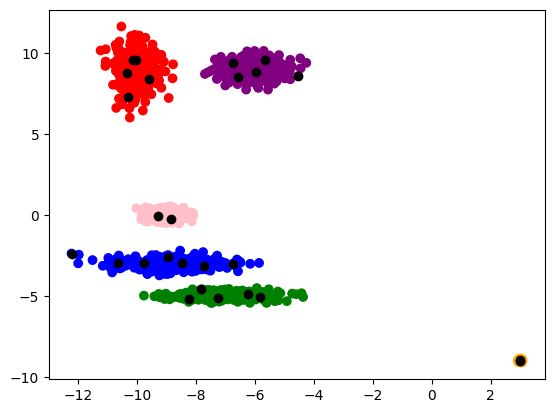

In [30]:
plt.scatter(color_points['x'],color_points['y'],color=color_points['color'])

for i in range(len(bCent.value)):
    plt.scatter(bCent.value[i][0],bCent.value[i][1],color='black')

for each row evaluate distance from new points --> if it's less than mindistance substitute

In [31]:
clean_X.printSchema()

root
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- minimum_cost: double (nullable = true)



# Step 4: Select a subset of the possible centroids using k-means ++

Using kmeans ++:

Algorithm 1 k-means++(k) initialization.
1: C ← sample a point uniformly at random from X
2: while |C| < k do
2
3:
Sample x ∈ X with probability dφX(x,C)
(C)
4:
C ← C ∪ {

#### Function to find closest center among list

In [32]:
# Define the function to find the closest center from any point in order to find the weights
def find_closest_center(xrow, broadC, num_cols=n_cols):
    '''Find the center in the broadcasted value 
    list whose distance from a dataframe.row 
    is the lowest:
    
    broadC = sc.broadcast(center_rows)
    xrow = clean_X.collect()[1]
    '''
    x = np.array(xrow)[:num_cols]
    centers = broadC.value
    the_ds = np.zeros(len(centers))
    
    for c in range(len(centers)):
        c_array = np.array(centers[c])[:num_cols]
        dist2 = np.linalg.norm(x - c_array)**2
        the_ds[c] = dist2
        
    return np.argmin(the_ds)

In [33]:
dfCent = spark.createDataFrame(bCent.value) 

In [34]:
over_sampled_centers = dfCent.count()

In [35]:
dfCent.rdd.getNumPartitions()

3

In [36]:
len(bCent.value)

26

## Reduce size of dfCent to have only `k` centroids 

#### Step 1: calc weights $w_x$
set wx to be the number of points in X closer to x than any other point in C

In [37]:
wx = clean_X.rdd.map(lambda row: (find_closest_center(row,bCent),1)).reduceByKey(lambda x,y: x+y).\
     takeOrdered(over_sampled_centers) #o lambda x,y: x+y

In [38]:
wx

[(0, 41),
 (1, 29),
 (2, 51),
 (3, 17),
 (4, 33),
 (5, 162),
 (6, 4),
 (7, 65),
 (8, 74),
 (9, 56),
 (10, 175),
 (11, 58),
 (12, 83),
 (13, 64),
 (14, 107),
 (15, 62),
 (16, 25),
 (17, 46),
 (18, 35),
 (19, 71),
 (20, 66),
 (21, 50),
 (22, 99),
 (23, 125),
 (24, 138),
 (25, 64)]

In [39]:
type(wx)

list

In [40]:
wx = (np.array(wx)[:,1]).astype(float)
wx

array([ 41.,  29.,  51.,  17.,  33., 162.,   4.,  65.,  74.,  56., 175.,
        58.,  83.,  64., 107.,  62.,  25.,  46.,  35.,  71.,  66.,  50.,
        99., 125., 138.,  64.])

In [41]:
wx /= np.sum(wx)
wx

array([0.02277778, 0.01611111, 0.02833333, 0.00944444, 0.01833333,
       0.09      , 0.00222222, 0.03611111, 0.04111111, 0.03111111,
       0.09722222, 0.03222222, 0.04611111, 0.03555556, 0.05944444,
       0.03444444, 0.01388889, 0.02555556, 0.01944444, 0.03944444,
       0.03666667, 0.02777778, 0.055     , 0.06944444, 0.07666667,
       0.03555556])

In [42]:
# Maybe we need to get rid of bCent ??
# bCent.destroy()
# bCent.unpersist()

#### Step 2: Use weighted `k-means++`
    2.1 Draw 1 random center
    2.2 update cost function
    2.3 repeat 1-2 until happy

In [43]:
# 2.1 Draw 1 random center

first_index = np.random.choice(a=range(wx.shape[0]), size=1, p=wx) 
#first point sampled uniformly wrt distance

first_index

array([23])

In [44]:
first_center = getrows(dfCent, first_index).collect()
first_center

[Row(x=2.995979049502984, y=-8.963598828105503, minimum_cost=431.82526488670516)]

In [45]:
# Adds the first center to the ultimate center
bCent_ultimate = sc.broadcast(first_center)
bCent_ultimate.value

[Row(x=2.995979049502984, y=-8.963598828105503, minimum_cost=431.82526488670516)]

In [46]:
# Define the total distance from other centers (minimum cost) over the chosen center
dfCent = (dfCent.select('*')
         .withColumn('minimum_cost', sum((col(colname)-first_center[0][colname])**2 for colname in colnames)))

In [47]:
# Initialize the total cost value
phi0 = np.log(dfCent.agg({"minimum_cost": "sum"}).collect()[0][0])
phi0

8.823634628199613

In [48]:
%%time

# 2.2 Update cost function

ultimate_sample_n = len(bCent_ultimate.value)

while ultimate_sample_n < k: #n_iter or len(bCent.value) < k:
    '''
    Nel ciclo for:
        - Evaluate for each row wx * d()^2 / phi
        - Sample with that probability
        - Broadcast centers to nodes
        - Evaluate new cost
        
    Ricordiamoci che distance è già al quadrato e che phi è il logaritmo
    '''
    
    # Evaluate the probability and select the new rows
    rows_prob = np.array(dfCent.rdd\
                .map(lambda row: distance(row,bCent_ultimate.value)).collect())
    # Forse pensare ad un modo alternativo di fare questo conto qui.... crescita lineare di bCent_ultimate
    
    # Sample new weighted random center
    another_index = np.random.choice(a=range(wx.shape[0]), size=1, p = rows_prob*wx/(rows_prob@wx) ) 
    another_center = getrows(dfCent, another_index).collect()
    
    # Update the broadcast
    bCent_ultimate = sc.broadcast(another_center + bCent_ultimate.value)
    
    # Update minimum cost
    dfCent = dfCent.select('*').\
    withColumn('minimum_cost', least('minimum_cost', sum((col(colname)-another_center[0][colname])**2 for colname in colnames) )).cache()
    
    # Evaluate new cost
    phi0 = np.log(dfCent.agg({"minimum_cost": "sum"}).collect()[0][0])
    
    ultimate_sample_n = len(bCent_ultimate.value)
    print("\n i: ",ultimate_sample_n)



 i:  2

 i:  3

 i:  4

 i:  5

 i:  6
CPU times: user 231 ms, sys: 45.1 ms, total: 276 ms
Wall time: 4.89 s


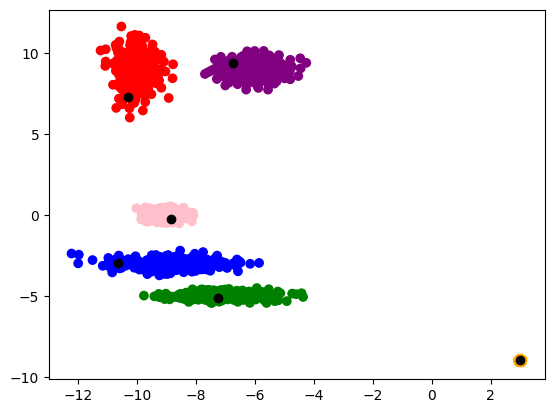

In [49]:
plt.scatter(color_points['x'],color_points['y'],color=color_points['color'])

for i in range(len(bCent_ultimate.value)):
    plt.scatter(bCent_ultimate.value[i][0],bCent_ultimate.value[i][1],color='black')

In [50]:
'''
- Prendere la lista dei centroidi e farla diventare un distributed dataset
- Fare una NUOVA lista di centroidi 
- for i in range(k):
    pesca un singolo dato con probabilità d(x)/phi --> come fare?
    aggiungilo alla lista

'''

'\n- Prendere la lista dei centroidi e farla diventare un distributed dataset\n- Fare una NUOVA lista di centroidi \n- for i in range(k):\n    pesca un singolo dato con probabilità d(x)/phi --> come fare?\n    aggiungilo alla lista\n\n'

# TO DO:
    - Capire come scegliere l
    - Fare la normalizzazione dei dati (se la facciamo)
    - Capire se abbiamo ottimizzato nel modo giusto
    - Implementare tutto k means (optional)
    - Creare un file gemello con un dataframe visualizzabile e vedere se ha senso
    - Iniziare a fare i benchmark su cloud veneto
    - Grafici etc...

# Stop worker and master
Stop the running Spark context (sc) and Spark session (spark)

In [52]:
#sc.stop()
#spark.stop()

Finally, use `docker compose down` to stop and clear all running containers.